In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

/home/okta/miniconda3/envs/data-analysis/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
def score_dataset(X, y, model=XGBRegressor()):
    # label encoding
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
        # Metric for housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [3]:
# Data
df = pd.read_csv("data/ames.csv")
X = df.copy()
y = X.pop("SalePrice")

## Mathematical Transforms
First, I will create the following features:
- `LivLotRatio`: the ratio of `GrLivArea` to `LotArea`
- `Spaciousness`: the sum of `FirstFlrSF` and `SecondFlrSF` divided by `TotRmsAbvGrd`
- `TotalOutsideSF`: the sum of `WoodDeckSF`, `OpenPorchSF`, `EnclosedPorch`, `Threeseasonporch`, and `ScreenPorch`

In [4]:
X_1 = pd.DataFrame()

X_1['LivLotRatio'] = X.GrLivArea / X.LotArea
X_1['Spaciousness'] = X[["FirstFlrSF", "SecondFlrSF"]].sum(axis=1) / X.TotRmsAbvGrd
X_1['TotalOutsideSF'] = X[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "Threeseasonporch", "ScreenPorch"]].sum(axis=1)

# checking result
X_1.head(10)

,LivLotRatio,Spaciousness,TotalOutsideSF
0,0.052125,236.571429,272.0
1,0.077095,179.200000,260.0
2,0.093152,221.500000,429.0
3,0.189068,263.750000,0.0
4,0.117787,271.500000,246.0
5,0.160754,229.142857,396.0
6,0.271951,223.000000,170.0
7,0.255744,256.000000,226.0
8,0.299870,323.200000,389.0
9,0.240533,257.714286,200.0


## Interaction with a Categorical
Based on previous analysis, interaction between BldgType and GrLivArea was discovered so I need to create interaction features between them.

In [5]:
# 1. One hot encoding the categorical
X_2 = pd.get_dummies(X["BldgType"], prefix="Bldg")

# 2. Multiply
X_2 = X_2.mul(X["GrLivArea"], axis=0)
X_2.head(10)

,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon
0,0.0,1656.0,0.0,0.0,0.0
1,0.0,896.0,0.0,0.0,0.0
2,0.0,1329.0,0.0,0.0,0.0
3,0.0,2110.0,0.0,0.0,0.0
4,0.0,1629.0,0.0,0.0,0.0
5,0.0,1604.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1338.0,0.0
7,0.0,0.0,0.0,1280.0,0.0
8,0.0,0.0,0.0,1616.0,0.0
9,0.0,1804.0,0.0,0.0,0.0


## Count Feature
I will create a feature that describe how many kinds of outdoor areas a dwelling has, by creating a feature that counts how many of the following are greater than 0:
- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- ThreeseasonPorch
- ScreenPorch

In [6]:
X_3 = pd.DataFrame()

X_3["PorchTypes"] = X[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "Threeseasonporch", "ScreenPorch"]].gt(0).sum(axis=1)
X_3

,PorchTypes
0,2
1,2
2,2
3,0
4,2
...,...
2925,1
2926,1
2927,2
2928,2


## Break Down a Categorical Feature
MSSubClass describes the type of a dwelling

In [7]:
df.MSSubClass.unique()

array(['One_Story_1946_and_Newer_All_Styles', 'Two_Story_1946_and_Newer',
       'One_Story_PUD_1946_and_Newer',
       'One_and_Half_Story_Finished_All_Ages', 'Split_Foyer',
       'Two_Story_PUD_1946_and_Newer', 'Split_or_Multilevel',
       'One_Story_1945_and_Older', 'Duplex_All_Styles_and_Ages',
       'Two_Family_conversion_All_Styles_and_Ages',
       'One_and_Half_Story_Unfinished_All_Ages',
       'Two_Story_1945_and_Older', 'Two_and_Half_Story_All_Ages',
       'One_Story_with_Finished_Attic_All_Ages',
       'PUD_Multilevel_Split_Level_Foyer',
       'One_and_Half_Story_PUD_All_Ages'], dtype=object)

As we can see above, the categorizations are too general, we need to narrow it. For that, I will create feature containing only the first words by splitting MSSubClass at the first underscore (_).

In [8]:
X_4 = pd.DataFrame()

X_4['MSClass'] = df.MSSubClass.str.split('_', n=1, expand=True)[0]

X_4

,MSClass
0,One
1,One
2,One
3,One
4,Two
...,...
2925,Split
2926,One
2927,Split
2928,One


## Grouped Transform
The value of a home often depends on how it compares to typical homes in its neighborhood. For that, I will create a feature `MedNhbdArea` that describes the median of `GrLivArea` grouped on Neighborhood.

In [9]:
X_5 = pd.DataFrame()

X_5['MedNhbdArea'] = df.groupby('Neighborhood')['GrLivArea'].transform("median")

In [10]:
X_5

,MedNhbdArea
0,1200.0
1,1200.0
2,1200.0
3,1200.0
4,1560.0
...,...
2925,1282.0
2926,1282.0
2927,1282.0
2928,1282.0


In [11]:
## combine all new feature
X_new = X.join([X_1, X_2, X_3, X_4, X_5])

In [12]:
X_new

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Spaciousness,TotalOutsideSF,Bldg_Duplex,Bldg_OneFam,Bldg_Twnhs,Bldg_TwnhsE,Bldg_TwoFmCon,PorchTypes,MSClass,MedNhbdArea
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,236.571429,272.0,0.0,1656.0,0.0,0.0,0.0,2,One,1200.0
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,179.200000,260.0,0.0,896.0,0.0,0.0,0.0,2,One,1200.0
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,221.500000,429.0,0.0,1329.0,0.0,0.0,0.0,2,One,1200.0
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,263.750000,0.0,0.0,2110.0,0.0,0.0,0.0,0,One,1200.0
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,271.500000,246.0,0.0,1629.0,0.0,0.0,0.0,2,Two,1560.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,Split_or_Multilevel,Residential_Low_Density,37.0,7937.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,CulDSac,...,167.166667,120.0,0.0,1003.0,0.0,0.0,0.0,1,Split,1282.0
2926,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,0.0,8885.0,Pave,No_Alley_Access,Slightly_Irregular,Low,AllPub,Inside,...,180.400000,164.0,0.0,902.0,0.0,0.0,0.0,1,One,1282.0
2927,Split_Foyer,Residential_Low_Density,62.0,10441.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,161.666667,112.0,0.0,970.0,0.0,0.0,0.0,2,Split,1282.0
2928,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,77.0,10010.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,231.500000,278.0,0.0,1389.0,0.0,0.0,0.0,2,One,1282.0


In [13]:
# Score the model with new features added:
score_dataset(X_new, y)

np.float64(0.13954039575734237)

# Clustering with K-Means

In this part, I will use unsupervised algorithm to discover feature. We don't give target to unsupervised algorithm, instead, it will find something by itself based on the data given. 

Clustering simply means the assigning of data points to groups based upon how similar the points are to each other. When used for feature engineering, we could attempt to discover groups of customers representing a market segment, for instance, or geographic areas that share similar weather patterns. Adding a feature of cluster labels can help machine learning models untangle complicated relationships of space or proximity.

## Cluesters Label as a Feature
When applied to real value, clustering acts like binning or discretization transform. On multiple features, it is more like multidimensional bining (vector quantization).

### NOTES:
- cluster feature is categorical
- Typical clustering algorithm produces label encoding, but depends on the model, one-hot encoding may be more appropriate.
- Clustering will break complicated relationship into simpler chunks then learn from that simple chunks on by one (divide and conquer)
- Below is the example of how clustering the x feature helps the model to learn its relationship with y.
  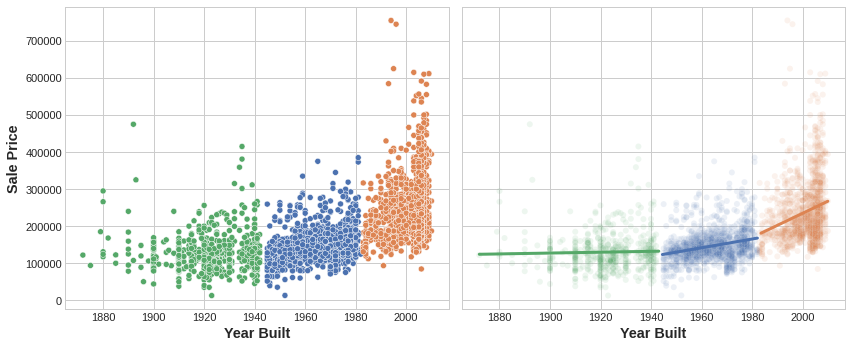

## k-Means Clustering
k-Means is one of the many clustering algorithm out there. Clustering algorithms have similar job, that is to cluster or grpup data points. The difference primarily in how the algorithm measure similarity or proximity, and in what kind of features they work with. 

in K-means clustering, it uses straight-line distance (Eculidean distance) to measure similarity. This means, k-Means creates clusters by placing centroids (number of points) inside the space of the feature. Then, each point in the dataset is assigned to the cluster of whichever centroid it's closest to. The "k" in "k-means" is how many centroids it creates, and it is define by us.

We could imagine each centroid capturing points through a sequence of radiating circles. When sets of circles from competing centroids overlap they form a line. The result is what's called a Voronoi tessallation. The tessallation shows you to what clusters future data will be assigned; the tessallation is essentially what k-means learns from its training data.

The clustering on the Ames dataset above is a k-means clustering. Here is the same figure with the tessallation and centroids shown.

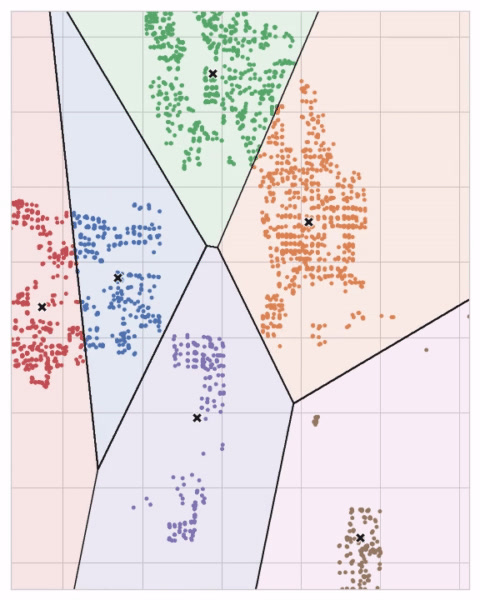

Let's review how the k-means algorithm learns the clusters and what that means for feature engineering. We'll focus on three parameters from scikit-learn's implementation: n_clusters, max_iter, and n_init.

k-means learns the cluster in two simple process, the  algorithm starts by randomly initializing some predefined number (n_clusters) of centroids. It then iterates over these two operations:
1. assign points to the nearest cluster centroid
2. move each centroid to minimize the distance to its points

It iterates over these two steps until the centroids aren't moving anymore, or until some maximum number of iterations has passed (max_iter).

It often happens that the initial random position of the centroids ends in a poor clustering. For this reason the algorithm repeats a number of times (n_init) and returns the clustering that has the least total distance between each point and its centroid, the optimal clustering.

The animation below shows the algorithm in action. It illustrates the dependence of the result on the initial centroids and the importance of iterating until convergence.
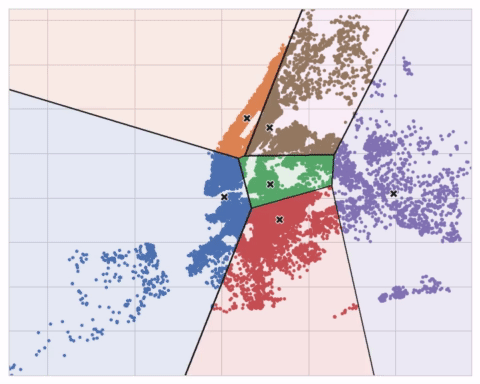

We may need to increase the `max_iter` for a large number of clusters or `n_init` for a complex dataset. Ordinarily though the only parameter we'll need to choose ourself is `n_clusters` (k, that is). The best partitioning for a set of features depends on the model we're using and what we're trying to predict, so it's best to tune it like any hyperparameter.

### Example - California Housing
As spatial features, California Housing's 'Latitude' and 'Longitude' make natural candidates for k-means clustering. In this example we'll cluster these with 'MedInc' (median income) to create economic segments in different regions of California.

In [14]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

df_cal = pd.read_csv("data/housing.csv")
X = df_cal.loc[:, ["MedInc", "Latitude", "Longitude"]]
X.head()

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25


Since k-means clustering is sensitive to scale, it can be a good idea rescale or normalize data with extreme values. Our features are already roughly on the same scale, so we'll leave them as-is.

In [15]:
from sklearn.cluster import KMeans

# Create cluster feature
kmeans = KMeans(n_clusters=6)
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X["Cluster"].unique

<bound method Series.unique of 0        4
1        4
2        4
3        4
4        1
        ..
20635    1
20636    1
20637    1
20638    1
20639    1
Name: Cluster, Length: 20640, dtype: category
Categories (6, int32): [0, 1, 2, 3, 4, 5]>

I will look at a couple plots to see how effective this was. First, a scatter plot that shows the geographic distribution of the clusters. It seems like the algorithm has created separate segments for higher-income areas on the coasts.

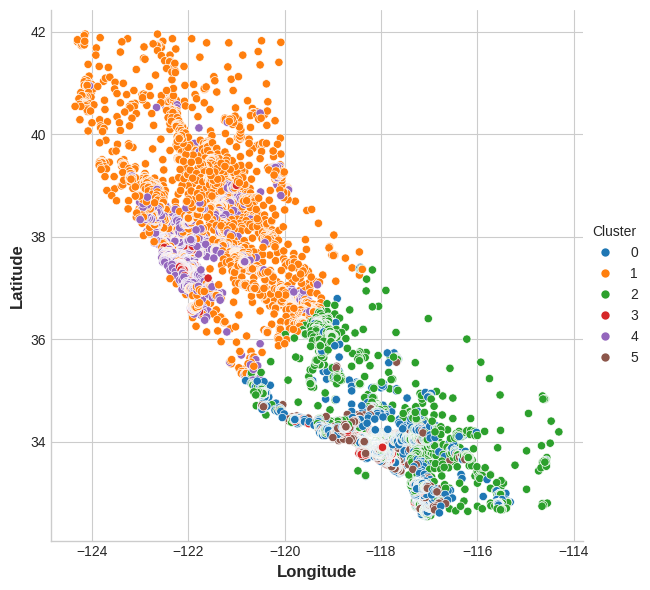

In [16]:
import seaborn as sns
sns.relplot(
    x="Longitude", y="Latitude", hue="Cluster", data=X, height=6,
);

The target in this dataset is `MedHouseVal` (median house value). These box-plots show the distribution of the target within each cluster. If the clustering is informative, these distributions should, for the most part, separate across `MedHouseVal`.

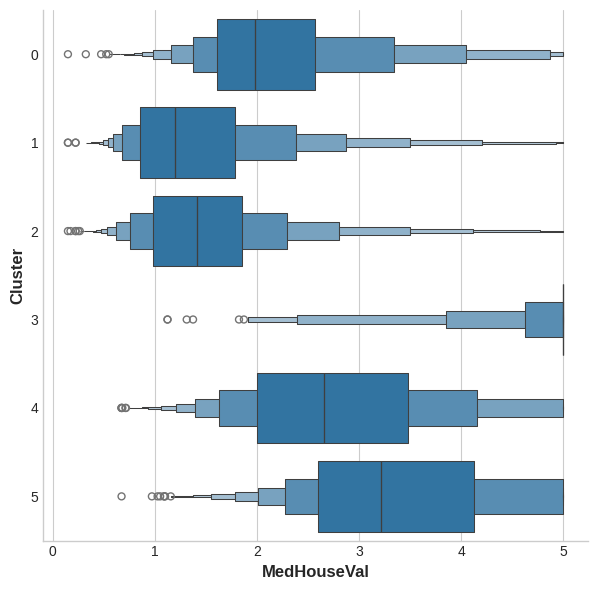

In [17]:
X["MedHouseVal"] = df_cal["MedHouseVal"]
sns.catplot(x="MedHouseVal", y="Cluster", data=X, kind="boxen", height=6);

As we can see above, for the most part, the distributions are separated across `MedHouseVal`.

## AMES

In [18]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categorical
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

# prepare data
df_ames = pd.read_csv("data/ames.csv")

The k-means algorithm is sensitive to scale. This means I need to be thoughtful about how and whether I rescale the features since I might get very different results depending on my choices. As a rule of thumb, if the features are already directly comparable (like a test result at different times), then we would not want to rescale. On the other hand, features that aren't on comparable scales (like height and weight) will usually benefit from rescaling. Sometimes, the choice won't be clear though. In that case, I should try to use common sense, remembering that features with larger values will be weighted more heavily.

### 1) Scaling Features
It is important to remember that we only need to rescalling if the features are not comparable, in other words if the features are on the same unit, no rescalling needed 

### 2) Create a Feature of Cluster Labels
I will create k-means clustering with the following features:
- features: `LotArea`, `TotalBsmtSF`, `FirstFlrSF`, `SecondFlrSF`, `GrLivArea`
- number of clusters: 10
- iterations: 10

In [67]:
X = df_ames.copy()
y = X.pop("SalePrice")

# Defining features
features = ["LotArea", "TotalBsmtSF", "FirstFlrSF", "SecondFlrSF", "GrLivArea"]
features

['LotArea', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'GrLivArea']

In [68]:
# Standardize the features
X_ames_scaled = X.loc[:, features]
X_ames_scaled = (X_ames_scaled - X_ames_scaled.mean(axis=0)) / X_ames_scaled.std(axis=0)

# fit the model to X_scaled 
kmeans = KMeans(n_clusters=10, random_state=0)
X["Cluster"] = kmeans.fit_predict(X_ames_scaled)

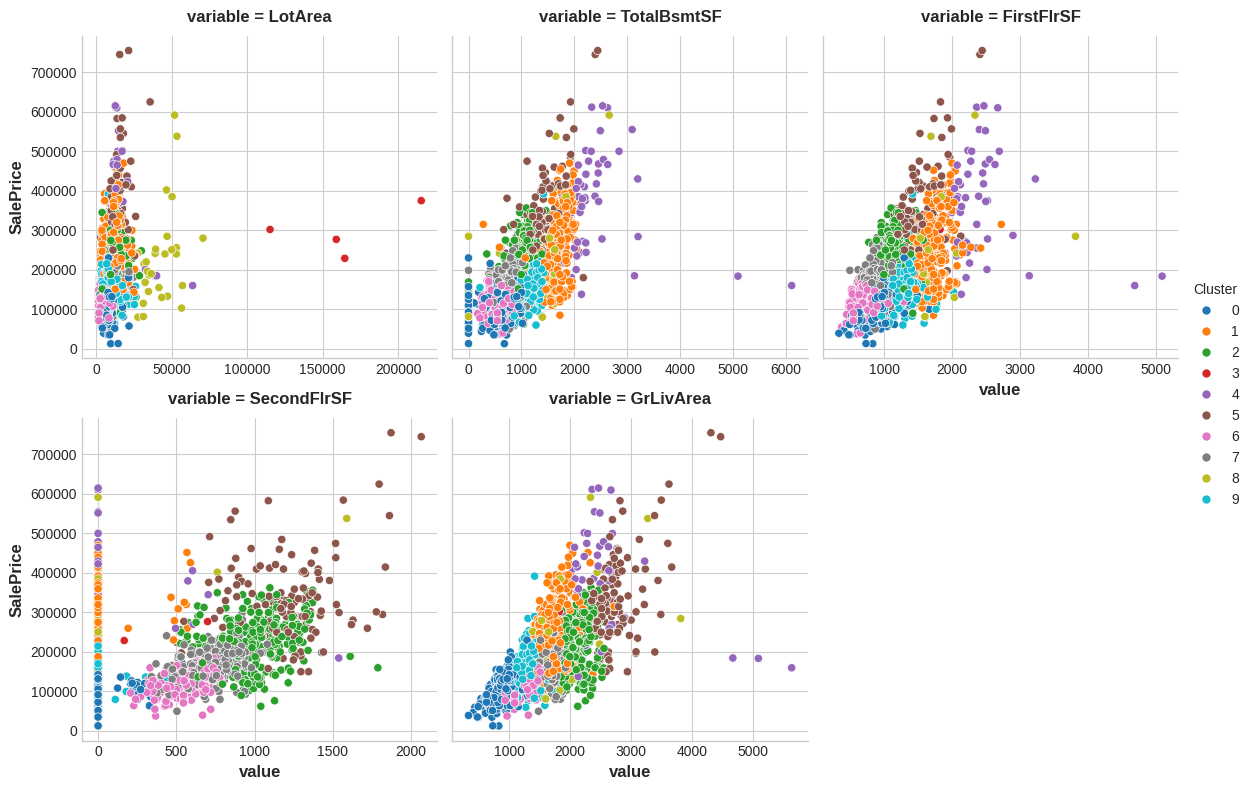

In [21]:
Xy = X.copy()
Xy["Cluster"] = Xy.Cluster.astype("category")
Xy["SalePrice"] = y
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex':False}, col_wrap=3,
    data=Xy.melt(
        value_vars=features, id_vars=["SalePrice", "Cluster"],
    ),
);

In [22]:
score_dataset(X,y)

np.float64(0.14243343405759998)

The k-means algorithm offers an alternative way of creating features. Instead of labelling each feature with the nearest cluster centroid, it can measure the distance from a point to all the centroids and return those distances as features.

### 3) Cluster-Distance Features

Now I will add the cluster-distance features to the dataset. Distance features can be obtained using the `fit_transform` method of kmeans instead of `fit_predict`.

In [23]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)

# Create the cluster-distance features using `fit_transform`
X_cd = kmeans.fit_transform(X_scaled)

# Label features and join to dataset
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Centroid_0,Centroid_1,Centroid_2,Centroid_3,Centroid_4,Centroid_5,Centroid_6,Centroid_7,Centroid_8,Centroid_9
0,0,0,141.0,31770.0,0,0,0,0,0,0,...,4.134181,3.236678,3.977023,4.316398,16.792665,13.097627,2.870851,3.789935,1.604330,3.315926
1,0,1,80.0,11622.0,0,0,1,0,0,1,...,4.615628,1.075352,0.621685,1.885029,19.594509,15.785445,2.575580,2.745164,4.932333,4.508933
2,0,0,81.0,14267.0,0,0,0,0,0,0,...,3.707220,0.953832,2.157567,2.713650,19.030448,14.058973,0.975653,2.618381,3.927018,2.780135
3,0,0,93.0,11160.0,0,0,1,0,0,0,...,3.874506,3.792481,5.085077,5.236814,19.392116,11.373003,2.243512,4.444882,4.673607,0.508460
4,1,0,74.0,13830.0,0,0,0,0,0,1,...,2.651716,2.070336,2.337714,1.306043,19.225117,14.749591,2.660527,0.733775,4.390193,4.103626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,6,0,37.0,7937.0,0,0,0,0,0,2,...,4.385914,0.632596,0.786743,1.872145,19.983709,15.515254,2.158623,2.615104,5.110022,4.128159
2926,0,0,0.0,8885.0,0,0,0,3,0,1,...,4.637266,1.039369,0.404809,1.791325,19.937172,15.897940,2.586619,2.737873,5.212695,4.548788
2927,4,0,62.0,10441.0,0,0,1,0,0,1,...,4.453410,0.806070,0.628910,1.845923,19.701445,15.610602,2.335405,2.629335,4.917455,4.284502
2928,0,0,77.0,10010.0,0,0,1,0,0,1,...,3.645022,0.954872,2.256738,2.748809,19.548612,14.012415,0.623647,2.635832,4.385419,2.586722


In [24]:
score_dataset(X, y)

np.float64(0.13558092074508335)

# Principal Component Analysis

PCA partitioning data based on variation. It helps us to discover important relationships in the data and can also be used to create informative features.

**NOTE:** PCA is typically applied to standardized data. With standardized data "variation" means "correlation". With unstandardized data "variation" means "covariance". All data will be and must be standardized before applying PCA.)

### Abalone Dataset
In the Abalone dataset are physical measurements taken from several thousand Tasmanian abalone. (An abalone is a sea creature much like a clam or an oyster.) We'll just look at a couple features for now: the 'Height' and 'Diameter' of their shells.

To better understand PCA, we can look at the picture below:
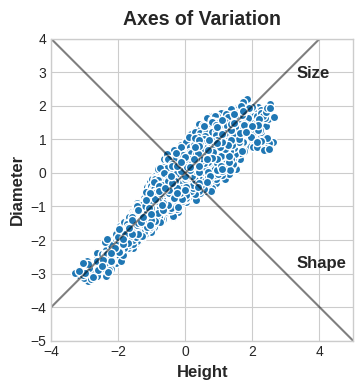

The figure above is the scatterplot of 

1. **The size component**: The size component is a line through the plot of height vs diameter of abalone. High size score means that the abalone has large height and diameter.
3. **The shape component**: the line drawn at 90^o angle to the size line. This line captures the differences between height and diameter. Positive score means that the abalone is tall but narrow and the negative score mean the abalone s short but wide (like pancake).

Instead of describing abalones by their 'Height' and 'Diameter', we could just as well describe them by their 'Size' and 'Shape'. This, in fact, is the whole idea of PCA: instead of describing the data with the original features, we describe it with its axes of variation. The axes of variation become the new features.

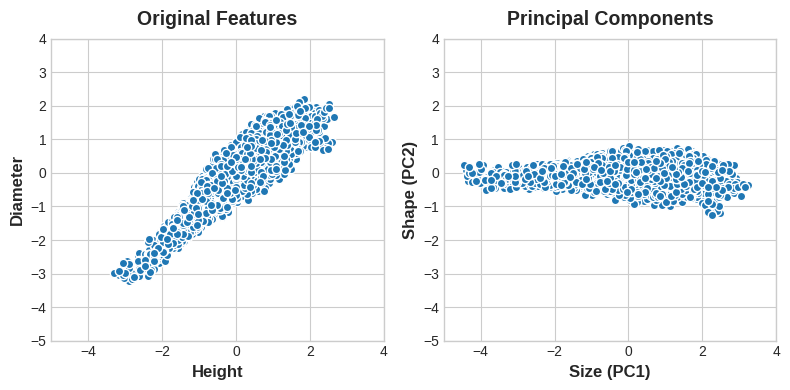

The new features PCA constructs are actually just linear combinations (weighted sums) of the original features:

```python
df["Size"] = 0.707 * X["Height"] + 0.707 * X["Diameter"]
df["Shape"] = 0.707 * X["Height"] - 0.707 * X["Diameter"]
```
These new features are called the principal components of the data. The weights themselves are called loadings. There will be as many principal components as there are features in the original dataset: if we had used ten features instead of two, we would have ended up with ten components.


## PCA for Feature Engineering
Two ways PCA could be used in feature engineering.
The first way is to use it as a descriptive technique. Since the components tell us about the variation, we could compute the MI scores for the components and see what kind of variation is most predictive of our target. That could give us ideas for kinds of features to create, a product of 'Height' and 'Diameter' if 'Size' is important, say, or a ratio of 'Height' and 'Diameter' if Shape is important. We could even try clustering on one or more of the high-scoring components.

The second way is to use the components themselves as features. Because the components expose the variational structure of the data directly, they can often be more informative than the original features. Here are some use-cases:

- Dimensionality reduction: When your features are highly redundant (multicollinear, specifically), PCA will partition out the redundancy into one or more near-zero variance components, which you can then drop since they will contain little or no information.
- Anomaly detection: Unusual variation, not apparent from the original features, will often show up in the low-variance components. These components could be highly informative in an anomaly or outlier detection task.
- Noise reduction: A collection of sensor readings will often share some common background noise. PCA can sometimes collect the (informative) signal into a smaller number of features while leaving the noise alone, thus boosting the signal-to-noise ratio.
- Decorrelation: Some ML algorithms struggle with highly-correlated features. PCA transforms correlated features into uncorrelated components, which could be easier for your algorithm to work with.

PCA basically gives us direct access to the correlational structure of our data. 

**PCA Best Practices**
There are a few things to keep in mind when applying PCA:
- PCA only works with numeric features, like continuous quantities or counts.
- PCA is sensitive to scale. It's good practice to standardize our data before applying PCA, unless we know you have good reason not to.
- Consider removing or constraining outliers, since they can have an undue influence on the results.

## Example - 1985 Automobiles¶
In this example, we'll use Automobile dataset and apply PCA, using it as a descriptive technique to discover features. We'll look at other use-cases in the exercise.

This hidden cell loads the data and defines the functions `plot_variance` and `make_mi_scores`.

In [26]:
def plot_variance(pca, width=8, dpi=100):
    # figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# data 
df_autos = pd.read_csv("data/autos.csv")

In [28]:
df_autos

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,-1,volvo,gas,std,4,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,9,114,5400,23,28,16845
189,-1,volvo,gas,turbo,4,sedan,rwd,front,109.1,188.8,...,141,mpfi,3.78,3.15,8,160,5300,19,25,19045
190,-1,volvo,gas,std,4,sedan,rwd,front,109.1,188.8,...,173,mpfi,3.58,2.87,8,134,5500,18,23,21485
191,-1,volvo,diesel,turbo,4,sedan,rwd,front,109.1,188.8,...,145,idi,3.01,3.40,23,106,4800,26,27,22470


I've selected four features that cover a range of properties. Each of these features also has a high MI score with the target, price. I'll standardize the data since these features aren't naturally on the same scale.

In [33]:
features = ["highway_mpg", "engine_size", "horsepower", "curb_weight"]

X = df_autos.copy()
y = X.pop("price")
X = X.loc[:, features]

# Standardize (Z-score)
X_autos_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
X_autos_scaled

,highway_mpg,engine_size,horsepower,curb_weight
0,-0.555613,0.045098,0.198054,-0.025646
1,-0.555613,0.045098,0.198054,-0.025646
2,-0.702307,0.574066,1.330822,0.496473
3,-0.115531,-0.459826,-0.039037,-0.426254
4,-1.289083,0.189362,0.303427,0.498371
...,...,...,...,...
188,-0.408919,0.309582,0.277084,0.741394
189,-0.849001,0.309582,1.488882,0.925560
190,-1.142389,1.078989,0.803953,0.855311
191,-0.555613,0.405758,0.066336,1.244527


Fit scikit-learn's PCA estimator and create the principal components. 

In [35]:
from sklearn.decomposition import PCA

# create pc
pca = PCA()
X_autos_pca = pca.fit_transform(X_autos_scaled)

# convert to df
component_names = [f"PC{i+1}" for i in range(X_autos_pca.shape[1])]
X_autos_pca = pd.DataFrame(X_autos_pca, columns=component_names)

X_autos_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


After fitting, the PCA instance contains the loadings in its `components_ attribute`. The loadings need to be wrappedup in a dataframe:

In [37]:
loadings = pd.DataFrame(
    pca.components_.T, # matrix transpose
    columns=component_names, # columns --> principal component
    index=X.columns, # row --> original featueres
) 
loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


Recall that the signs and magnitudes of a component's loadings tell us what kind of variation it's captured. The first component (PC1) shows a contrast between large, powerful vehicles with poor gas milage, and smaller, more economical vehicles with good gas milage. We might call this the "Luxury/Economy" axis. The next figure shows that our four chosen features mostly vary along the Luxury/Economy axis.

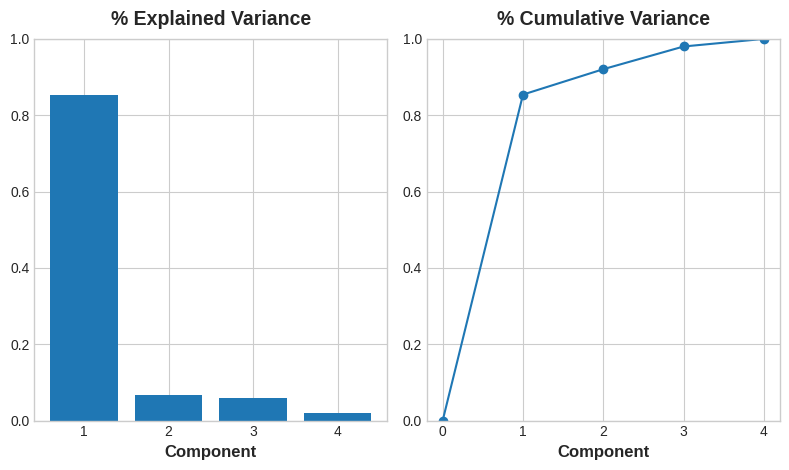

In [39]:
plot_variance(pca);

Let's also look at the MI scores of the components. Not surprisingly, PC1 is highly informative, though the remaining components, despite their small variance, still have a significant relationship with price. Examining those components could be worthwhile to find relationships not captured by the main Luxury/Economy axis.



In [42]:
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression

mi_scores = make_mi_scores(X_autos_pca, y, discrete_features=False)
mi_scores

PC1    1.012812
PC2    0.379279
PC3    0.306699
PC4    0.204550
Name: MI Scores, dtype: float64

In [43]:
# show dataframe sorted by pc3
idx = X_autos_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body_style", "horsepower", "curb_weight"]
df_autos.loc[idx, cols]

,make,body_style,horsepower,curb_weight
118,porsche,hardtop,207,2756
117,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


To express this contrast, I'll create a new ratio feature:

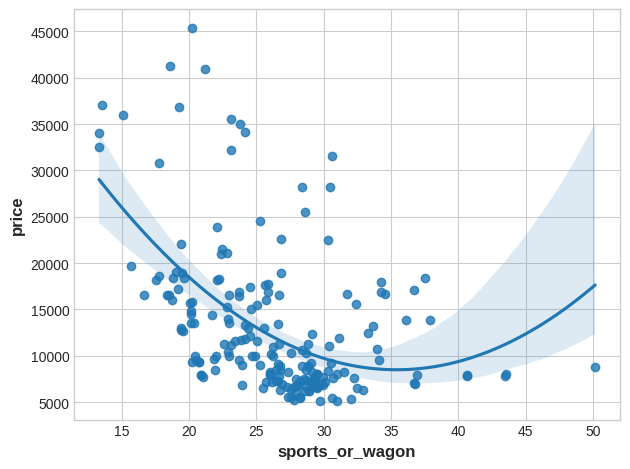

In [58]:
df_autos["sports_or_wagon"] = X.curb_weight / X.horsepower
sns.regplot(x="sports_or_wagon", y = "price", data=df_autos, order=2);